# CORPUS-INFORMED AUTO-TRANSLATOR: VECTOR CREATION NOTEBOOK
Day 3: Converting JSON Document into Semantic Vectors
(Creating vectors from a single corpus item)

## Notebook Outline

**Part 1: Data Preparation and Planning**

- STEP 1: LOAD THE REQUIRED LIBRARIES
- STEP 2: LOAD AND EXAMINE DATABASE STRUCTURE
- STEP 3: LOAD AND EXAMINE INDIVIDUAL CORPUS ITEM

**Part 2: Function and Model Setup**

- STEP 4: INITIALIZE THE MULTILINGUAL EMBEDDING MODEL (WITH DEMONSTRATION)
- STEP 5: PREPARE THE VECTOR STORAGE STRUCTURE (SCHEMA COMPLIANT)
- STEP 6: DEFINE TEXT EXTRACTION FUNCTIONS
- STEP 7: CREATE VECTORIZATION FUNCTIONS

**Part 3: Execution and Output**
- STEP 8: BATCH PROCESS DOCUMENTS
- STEP 9: VISUALIZE THE VECTORS

## =============================================================================

## Part 1: Data Preparation and Planning

### STEP 1: LOAD THE REQUIRED LIBRARIES

In [ ]:
### STEP 1: LOAD THE REQUIRED LIBRARIES

# Core Python libraries
import os
import json
from pathlib import Path
import logging
from typing import Dict, List, Tuple, Optional
from datetime import datetime

# Data processing libraries
import pandas as pd
import numpy as np

# Text processing libraries
import re
from collections import defaultdict

# Machine learning and embedding libraries
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

# Progress tracking (helpful for long processing times)
from tqdm.notebook import tqdm

# Visualization libraries (for testing our vectors)
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration management
import sys
sys.path.append('../scripts')  # Add scripts folder to path
from config import *  # Import all our configuration settings

# Set up logging for debugging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

print("✅ All libraries loaded successfully!")

# Display current configuration for workshop participants
print("\n" + "="*60)
print("🔧 CURRENT CONFIGURATION SETTINGS")
print("="*60)
print(f"Domain: {DOMAIN}")
print(f"Languages: {', '.join(LANGUAGES)}")
print(f"Model: {MODEL_NAME}")
print(f"Max text length: {MAX_TEXT_LENGTH:,} characters")
print(f"Create document vectors: {CREATE_DOCUMENT_VECTORS}")
print(f"Create section vectors: {CREATE_SECTION_VECTORS}")
print(f"Create paragraph vectors: {CREATE_PARAGRAPH_VECTORS}")

✅ All libraries loaded successfully!

🔧 CURRENT CONFIGURATION SETTINGS
Domain: gai
Languages: eng, esp
Model: distiluse-base-multilingual-cased-v2
Max text length: 8,000 characters
Create document vectors: True
Create section vectors: True
Create paragraph vectors: True


### STEP 2: LOAD AND EXAMINE DATABASE STRUCTURE

In [8]:
### STEP 2: LOAD AND EXAMINE DATABASE STRUCTURE

def load_database_file(language):
    """Load the database file for a specific language"""
    database_path = Path(CORPORA_DIR) / language / f"{DOMAIN}-{language}_database.json"
    
    if not database_path.exists():
        raise FileNotFoundError(f"Database file not found: {database_path}")
    
    with open(database_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def extract_documents_from_db(db, language):
    """Extract document data from database, handling different structures"""
    documents = {}
    
    # Get documents from nested 'documents' key
    if 'documents' in db and isinstance(db['documents'], dict):
        nested_docs = {k: v for k, v in db['documents'].items() 
                      if k.startswith(f'{DOMAIN}-{language}_item')}
        documents.update(nested_docs)
    
    # Also check for direct top-level document keys
    top_level_docs = {k: v for k, v in db.items() 
                     if k != f'{DOMAIN}_template' and k != 'documents' 
                     and k.startswith(f'{DOMAIN}-{language}_item')}
    documents.update(top_level_docs)
    
    return documents

# Load databases for all languages
print("🔍 Loading corpus databases...")

databases = {}
all_documents = {}
failed_languages = []

for language in LANGUAGES:
    try:
        databases[language] = load_database_file(language)
        all_documents[language] = extract_documents_from_db(databases[language], language)
        print(f"✅ {language.upper()}: {len(all_documents[language])} documents loaded")
        
        # Show all document IDs and titles for this language
        if all_documents[language]:
            print(f"   All document IDs:")
            for i, (doc_id, doc_data) in enumerate(all_documents[language].items(), 1):
                title = doc_data.get('document_metadata', {}).get('title', 'No title')
                print(f"     {i:2d}. {doc_id}: {title[:60]}{'...' if len(title) > 60 else ''}")
        print()  # Add blank line between languages
        
    except FileNotFoundError as e:
        failed_languages.append(language)
        print(f"❌ {language.upper()}: Database not found")

# Show overall results
total_documents = sum(len(docs) for docs in all_documents.values())
print(f"📊 Total: {total_documents} documents across {len(databases)} languages")

# Create summary for easy access by later steps
document_summary = {
    'total_count': total_documents,
    'by_language': {lang: len(docs) for lang, docs in all_documents.items()},
    'all_documents': all_documents
}

print(f"✅ Database loading complete! Ready for vectorization.")

# Only show errors if any occurred
if failed_languages:
    print(f"\n⚠️  Failed to load: {', '.join(failed_languages)}")
    for lang in failed_languages:
        expected_path = Path(CORPORA_DIR) / lang / f"{DOMAIN}-{lang}_database.json"
        print(f"   Expected: {expected_path}")

🔍 Loading corpus databases...
✅ ENG: 4 documents loaded
   All document IDs:
      1. gai-eng_item001: Attention is All You Need
      2. gai-eng_item002: On the Dangers of Stochastic Parrots: Can Language Models Be...
      3. gai-eng_item003: Recommendation on the Ethics of Artificial Intelligence
      4. gai-eng_item004: The Age of AI has begun

✅ ESP: 2 documents loaded
   All document IDs:
      1. gai-esp_item001: Propuesta de Agenda Nacional de la Inteligencia Artificial p...
      2. gai-esp_item002: Conversando con una computadora: ¿Cómo entienden las intelig...

📊 Total: 6 documents across 2 languages
✅ Database loading complete! Ready for vectorization.


### STEP 3: LOAD AND EXAMINE INDIVIDUAL CORPUS ITEM

In [9]:
### STEP 3: LOAD AND EXAMINE INDIVIDUAL CORPUS ITEM

def load_corpus_item(language, item_id):
    """Load a specific corpus item JSON file (content only)"""
    item_path = Path(CORPORA_DIR) / language / "processed" / f"{item_id}.json"
    
    if not item_path.exists():
        raise FileNotFoundError(f"Corpus item not found: {item_path}")
    
    with open(item_path, 'r', encoding='utf-8') as f:
        return json.load(f)

def get_document_metadata(databases, language, item_id):
    """Get metadata for a document from the database"""
    db = databases.get(language, {})
    documents = db.get('documents', {})
    return documents.get(item_id, {})

def merge_content_and_metadata(content_data, metadata):
    """Merge content and metadata into a complete document object"""
    return {
        'document_id': content_data.get('document_id'),
        'document_metadata': metadata.get('document_metadata', {}),
        'processing_metadata': metadata.get('processing_metadata', {}),
        'content': content_data.get('content', {})
    }

def analyze_corpus_structure(corpus_item):
    """Analyze document structure for vectorization planning"""
    analysis = {
        'document_id': corpus_item.get('document_id', 'Unknown'),
        'title': corpus_item.get('document_metadata', {}).get('title', 'No title'),
        'language': corpus_item.get('document_metadata', {}).get('language_family', 'Unknown'),  # FIXED: Use language_family
        'text_type': corpus_item.get('document_metadata', {}).get('text_type', 'Unknown'),
        'word_count': corpus_item.get('processing_metadata', {}).get('word_count', 0),
        'has_abstract': bool(corpus_item.get('content', {}).get('abstract')),
        'abstract_length': len(corpus_item.get('content', {}).get('abstract', '')),
        'sections': [],
        'total_paragraphs': 0,
        'total_subsections': 0,
        'total_subsubsections': 0,
        'total_text_length': 0
    }
    
    # Analyze sections and count all structural elements
    content = corpus_item.get('content', {})
    sections = content.get('sections', [])
    
    for section in sections:
        section_info = {
            'title': section.get('title', 'No title'),
            'main_paragraphs': len(section.get('paragraphs', [])),
            'subsections': [],
            'total_section_paragraphs': 0
        }
        
        # Count main section paragraphs
        section_info['total_section_paragraphs'] += section_info['main_paragraphs']
        analysis['total_paragraphs'] += section_info['main_paragraphs']
        
        # Calculate text length
        for paragraph in section.get('paragraphs', []):
            analysis['total_text_length'] += len(paragraph.get('text', ''))
        
        # Process subsections
        for subsection in section.get('subsections', []):
            subsection_paragraphs = len(subsection.get('paragraphs', []))
            section_info['total_section_paragraphs'] += subsection_paragraphs
            analysis['total_paragraphs'] += subsection_paragraphs
            analysis['total_subsections'] += 1
            
            # Add text length
            for paragraph in subsection.get('paragraphs', []):
                analysis['total_text_length'] += len(paragraph.get('text', ''))
            
            # Count subsubsections
            subsubsections = subsection.get('subsubsections', [])
            for subsubsection in subsubsections:
                subsubsection_paragraphs = len(subsubsection.get('paragraphs', []))
                section_info['total_section_paragraphs'] += subsubsection_paragraphs
                analysis['total_paragraphs'] += subsubsection_paragraphs
                analysis['total_subsubsections'] += 1
                
                # Add text length
                for paragraph in subsubsection.get('paragraphs', []):
                    analysis['total_text_length'] += len(paragraph.get('text', ''))
        
        analysis['sections'].append(section_info)
    
    # Add abstract to total text length
    analysis['total_text_length'] += analysis['abstract_length']
    
    return analysis

def display_analysis(analysis):
    """Display streamlined analysis for workshop"""
    
    print(f"\n📊 DOCUMENT ANALYSIS")
    print(f"🔖 {analysis['document_id']}: {analysis['title']}")
    print(f"🌐 Language: {analysis['language'].upper()}")
    print(f"📄 Type: {analysis['text_type']}")
    print(f"📏 {analysis['word_count']:,} words | {analysis['total_text_length']:,} characters")
    
    print(f"\n📋 STRUCTURE SUMMARY")
    print(f"📝 Abstract: {'✅' if analysis['has_abstract'] else '❌'} ({analysis['abstract_length']:,} chars)")
    print(f"📚 Sections: {len(analysis['sections'])}")
    print(f"📂 Subsections: {analysis['total_subsections']}")
    print(f"🔗 Sub-subsections: {analysis['total_subsubsections']}")
    print(f"📝 Total paragraphs: {analysis['total_paragraphs']}")
    
    print(f"\n📑 SECTION OVERVIEW")
    for i, section in enumerate(analysis['sections'], 1):
        title = section['title'][:40] + '...' if len(section['title']) > 40 else section['title']
        print(f"  {i:2d}. {title} ({section['total_section_paragraphs']} paragraphs)")
    
    print(f"\n🎯 VECTORIZATION PLAN")
    document_vectors = 1
    section_vectors = len(analysis['sections'])
    subsection_vectors = analysis['total_subsections']
    subsubsection_vectors = analysis['total_subsubsections']
    paragraph_vectors = analysis['total_paragraphs']
    total_vectors = document_vectors + section_vectors + subsection_vectors + subsubsection_vectors + paragraph_vectors
    
    print(f"📄 Document level: {document_vectors}")
    print(f"📚 Section level: {section_vectors}")
    print(f"📂 Subsection level: {subsection_vectors}")
    print(f"🔗 Sub-subsection level: {subsubsection_vectors}")
    print(f"📝 Paragraph level: {paragraph_vectors}")
    print(f"🎯 Total vectors: {total_vectors}")

# Load and analyze test document
test_doc_id = "gai-eng_item001" 
test_language = "eng"

print(f"📖 Loading corpus item: {test_doc_id}")

try:
    # Load content and metadata
    content_data = load_corpus_item(test_language, test_doc_id)
    
    if test_language in databases:
        metadata = get_document_metadata(databases, test_language, test_doc_id)
        corpus_item = merge_content_and_metadata(content_data, metadata)
        
        # Analyze and display
        analysis = analyze_corpus_structure(corpus_item)
        display_analysis(analysis)
        
        print(f"\n✅ Document analysis complete! Ready for vectorization.")
        
    else:
        print(f"❌ Database for {test_language} not loaded")
    
except FileNotFoundError as e:
    print(f"❌ File not found: {test_doc_id}.json")
    print(f"💡 Expected location: {Path(CORPORA_DIR) / test_language / 'processed' / f'{test_doc_id}.json'}")
except Exception as e:
    print(f"❌ Error: {e}")

# Store analysis for next steps
if 'analysis' in locals():
    test_document_analysis = analysis
    print(f"\n📋 Analysis stored as 'test_document_analysis' for next steps")

📖 Loading corpus item: gai-eng_item001

📊 DOCUMENT ANALYSIS
🔖 gai-eng_item001: Attention is All You Need
🌐 Language: ENG
📄 Type: Academic paper
📏 5,817 words | 24,391 characters

📋 STRUCTURE SUMMARY
📝 Abstract: ✅ (1,139 chars)
📚 Sections: 7
📂 Subsections: 12
🔗 Sub-subsections: 3
📝 Total paragraphs: 69

📑 SECTION OVERVIEW
   1. Introduction (4 paragraphs)
   2. Background (4 paragraphs)
   3. Model Architecture (29 paragraphs)
   4. 4 Why Self-Attention (6 paragraphs)
   5. Training (9 paragraphs)
   6. Results (12 paragraphs)
   7. 7 Conclusion (5 paragraphs)

🎯 VECTORIZATION PLAN
📄 Document level: 1
📚 Section level: 7
📂 Subsection level: 12
🔗 Sub-subsection level: 3
📝 Paragraph level: 69
🎯 Total vectors: 92

✅ Document analysis complete! Ready for vectorization.

📋 Analysis stored as 'test_document_analysis' for next steps


## =============================================================================

## Part 2: Function and Model Setup

### STEP 4: INITIALIZE THE MULTILINGUAL EMBEDDING MODEL

In [12]:
# STEP 4: INITIALIZE THE MULTILINGUAL EMBEDDING MODEL
# BLOCK 1: Load the model

print("🤖 Loading multilingual embedding model...")
print("📥 This may take a moment on first run as it downloads the model (~500MB)")

try:
    # Load the cross-lingual model (UPDATED MODEL!)
    model = SentenceTransformer('distiluse-base-multilingual-cased-v2')
    print("✅ Model loaded successfully!")
    
    # Display model information
    print(f"\n📊 MODEL INFORMATION")
    print(f"🏷️  Model: distiluse-base-multilingual-cased-v2")
    print(f"📐 Embedding dimension: {model.get_sentence_embedding_dimension()}")
    print(f"📏 Max sequence length: {model.max_seq_length}")
    print(f"🌐 Cross-lingual: Maps Spanish + English to same vector space")
    print(f"⚡ Optimized: 135M parameters")
    
except Exception as e:
    print(f"❌ Error loading model: {e}")
    print("💡 Troubleshooting:")
    print("   1. Check internet connection (model downloads from Hugging Face)")
    print("   2. Ensure sentence-transformers is installed: pip install sentence-transformers")
    print("   3. Try restarting kernel if you see cache issues")

2025-05-30 02:16:32,625 - INFO - Use pytorch device_name: cpu
2025-05-30 02:16:32,626 - INFO - Load pretrained SentenceTransformer: distiluse-base-multilingual-cased-v2


🤖 Loading multilingual embedding model...
📥 This may take a moment on first run as it downloads the model (~500MB)
✅ Model loaded successfully!

📊 MODEL INFORMATION
🏷️  Model: distiluse-base-multilingual-cased-v2
📐 Embedding dimension: 512
📏 Max sequence length: 128
🌐 Cross-lingual: Maps Spanish + English to same vector space
⚡ Optimized: 135M parameters


#### DEMONSTRATION: UNIFIED VECTOR SPACE FOR BILINGUAL CONTENT

In [13]:
# STEP 4: INITIALIZE THE MULTILINGUAL EMBEDDING MODEL
# BLOCK 2: Demonstrate the unified vector space
print("\n🌐 DEMONSTRATING UNIFIED VECTOR SPACE:")
print("=" * 60)

# Test sentences in English and Spanish (related to your corpus domain)
test_sentences = [
    "Artificial intelligence is transforming education worldwide",  # English
    "La inteligencia artificial está transformando la educación mundial",  # Spanish (same meaning)
    "Machine learning algorithms require large datasets for training",  # English
    "Los algoritmos de aprendizaje automático requieren grandes conjuntos de datos",  # Spanish (same meaning)
    "The weather forecast shows rain tomorrow",  # English (unrelated topic)
    "El pronóstico del tiempo muestra lluvia mañana"  # Spanish (unrelated topic)
]

# Create embeddings
print("🔄 Creating embeddings for test sentences...")
test_embeddings = model.encode(test_sentences)
print(f"✅ Generated {len(test_embeddings)} embeddings of {test_embeddings[0].shape[0]} dimensions each")

# Calculate similarity between English and Spanish pairs
print("\n📈 SIMILARITY SCORES (0-1, higher = more similar):")
print("-" * 60)

# Compare sentence pairs
for i in range(0, len(test_sentences), 2):
    eng_sentence = test_sentences[i]
    spa_sentence = test_sentences[i+1]
    
    similarity = cosine_similarity(
        test_embeddings[i].reshape(1, -1),
        test_embeddings[i+1].reshape(1, -1)
    )[0][0]
    
    print(f"\n🔤 English: '{eng_sentence[:45]}...'")
    print(f"🔤 Spanish: '{spa_sentence[:45]}...'")
    print(f"📊 Similarity: {similarity:.4f} {'✅ High cross-lingual similarity!' if similarity > 0.7 else '⚠️  Lower similarity'}")

# Show that unrelated sentences have lower similarity
print(f"\n🔍 CROSS-TOPIC COMPARISON (unrelated content):")
unrelated_sim = cosine_similarity(
    test_embeddings[0].reshape(1, -1),  # AI sentence in English
    test_embeddings[4].reshape(1, -1)   # Weather sentence in English
)[0][0]
print(f"'AI education...' vs 'Weather forecast...': {unrelated_sim:.4f}")
print(f"💡 Notice how related topics have higher similarity than unrelated ones!")

if test_embeddings[0].shape[0] == 512:
    print(f"\n✅ READY FOR CORPUS VECTORIZATION")
    print(f"📋 Model will create 512-dimensional vectors for your authentic corpora")
else:
    print(f"\n⚠️  Unexpected embedding dimension: {test_embeddings[0].shape[0]}")


🌐 DEMONSTRATING UNIFIED VECTOR SPACE:
🔄 Creating embeddings for test sentences...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Generated 6 embeddings of 512 dimensions each

📈 SIMILARITY SCORES (0-1, higher = more similar):
------------------------------------------------------------

🔤 English: 'Artificial intelligence is transforming educa...'
🔤 Spanish: 'La inteligencia artificial está transformando...'
📊 Similarity: 0.9767 ✅ High cross-lingual similarity!

🔤 English: 'Machine learning algorithms require large dat...'
🔤 Spanish: 'Los algoritmos de aprendizaje automático requ...'
📊 Similarity: 0.8797 ✅ High cross-lingual similarity!

🔤 English: 'The weather forecast shows rain tomorrow...'
🔤 Spanish: 'El pronóstico del tiempo muestra lluvia mañan...'
📊 Similarity: 0.9757 ✅ High cross-lingual similarity!

🔍 CROSS-TOPIC COMPARISON (unrelated content):
'AI education...' vs 'Weather forecast...': 0.0426
💡 Notice how related topics have higher similarity than unrelated ones!

✅ READY FOR CORPUS VECTORIZATION
📋 Model will create 512-dimensional vectors for your authentic corpora



📊 VISUALIZING THE UNIFIED VECTOR SPACE:
🔄 Reducing 512 dimensions to 2D for visualization...
🔗 Drawing connections between translation pairs...


C:\Users\alain\AppData\Local\Temp\ipykernel_20672\2078768525.py:57: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\alain\AppData\Local\Temp\ipykernel_20672\2078768525.py:57: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\alain\AppData\Local\Temp\ipykernel_20672\2078768525.py:57: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\alain\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\alain\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans

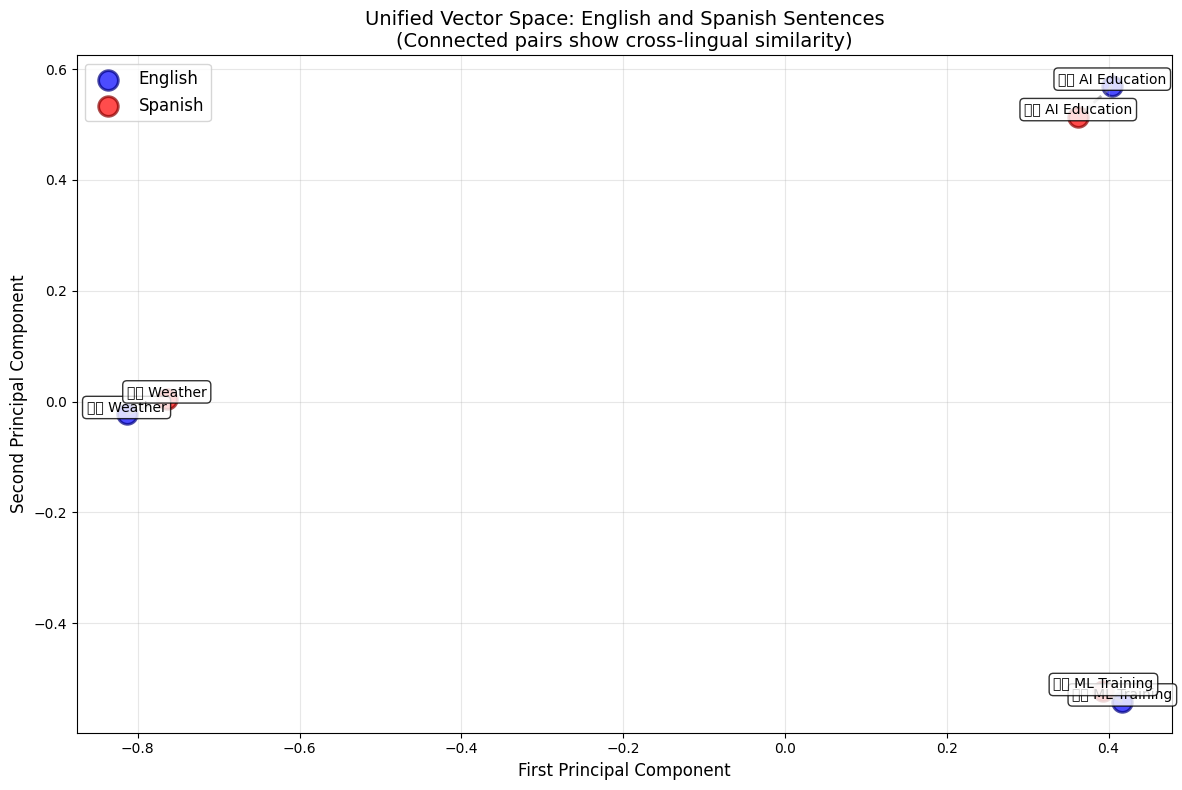


💡 KEY OBSERVATIONS:
🔗 Translation pairs (connected by lines) cluster together
📊 Similar topics group near each other regardless of language
🌐 This demonstrates our truly multilingual vector space!

✅ MODEL READY FOR CORPUS VECTORIZATION
📋 Your authentic Spanish and English texts will map to this same unified space


In [14]:
# STEP 4: INITIALIZE THE MULTILINGUAL EMBEDDING MODEL
# BLOCK 3: Visualize the unified vector space
print("\n📊 VISUALIZING THE UNIFIED VECTOR SPACE:")
print("=" * 60)

# Reduce dimensions for visualization
print("🔄 Reducing 512 dimensions to 2D for visualization...")
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(test_embeddings)

# Create visualization
plt.figure(figsize=(12, 8))

# Plot English sentences (blue)
eng_indices = list(range(0, len(test_sentences), 2))
plt.scatter(embeddings_2d[eng_indices, 0], embeddings_2d[eng_indices, 1], 
           c='blue', s=200, alpha=0.7, label='English', edgecolors='navy', linewidth=2)

# Plot Spanish sentences (red)
spa_indices = list(range(1, len(test_sentences), 2))
plt.scatter(embeddings_2d[spa_indices, 0], embeddings_2d[spa_indices, 1], 
           c='red', s=200, alpha=0.7, label='Spanish', edgecolors='darkred', linewidth=2)

# Add labels for each point
for i, sentence in enumerate(test_sentences):
    # Shorten text for display
    if 'inteligencia artificial' in sentence or 'Artificial intelligence' in sentence:
        display_text = "AI Education"
    elif 'aprendizaje automático' in sentence or 'Machine learning' in sentence:
        display_text = "ML Training"
    elif 'tiempo' in sentence or 'weather' in sentence:
        display_text = "Weather"
    else:
        display_text = sentence[:20] + "..."
    
    # Add language indicator
    lang = "🇪🇸" if i % 2 == 1 else "🇺🇸"
    display_text = f"{lang} {display_text}"
    
    plt.annotate(display_text, 
                (embeddings_2d[i, 0], embeddings_2d[i, 1]), 
                fontsize=10, ha='center', va='bottom',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))

# Draw lines between translation pairs
print("🔗 Drawing connections between translation pairs...")
for i in range(0, len(test_sentences), 2):
    plt.plot([embeddings_2d[i, 0], embeddings_2d[i+1, 0]], 
             [embeddings_2d[i, 1], embeddings_2d[i+1, 1]], 
             'gray', linestyle='--', alpha=0.6, linewidth=2)

plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.title('Unified Vector Space: English and Spanish Sentences\n(Connected pairs show cross-lingual similarity)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n💡 KEY OBSERVATIONS:")
print(f"🔗 Translation pairs (connected by lines) cluster together")
print(f"📊 Similar topics group near each other regardless of language")
print(f"🌐 This demonstrates our truly multilingual vector space!")
print(f"\n✅ MODEL READY FOR CORPUS VECTORIZATION")
print(f"📋 Your authentic Spanish and English texts will map to this same unified space")

### STEP 5: PREPARE THE VECTOR STORAGE STRUCTURE (SCHEMA COMPLIANT)

Note: Consider adding "text_length" to vector structure in a future iteration

In [28]:
### STEP 5: PREPARE THE VECTOR STORAGE STRUCTURE (SCHEMA COMPLIANT)

print("📦 PREPARING VECTOR STORAGE STRUCTURE")
print("=" * 60)

print("✅ Using standardized schema for vector storage")
print("📋 Schema structure:")
print("  • metadata: Model name and embedding dimensions")
print("  • vectors: Array of vector objects with:")
print("    - Document vectors: id, title, count, created, vector, text")
print("    - Section vectors: id, document_id, title, level, count, created, vector, text")
print("    - Paragraph vectors: id, document_id, count, created, vector, text")
print("  • Full text content stored (no length limitations)")

def save_document_vectors_json(vectors_data, filename, model):
    """Save document vectors to JSON file following the standardized schema"""
    
    vector_objects = []
    
    for i, vector_info in enumerate(vectors_data, 1):
        vector_obj = {
            "id": vector_info['id'],  # document_id
            "title": vector_info.get('title', 'No title'),
            "count": i,
            "created": datetime.now().isoformat(),
            "text": vector_info.get('text', ''),  # Full text, no truncation
            "vector": vector_info['vector'].tolist() if hasattr(vector_info['vector'], 'tolist') else vector_info['vector']
        }
        vector_objects.append(vector_obj)
    
    # Create the complete data structure following schema
    vector_data = {
        "metadata": {
            "model": "distiluse-base-multilingual-cased-v2",  # UPDATED MODEL
            "dimension": model.get_sentence_embedding_dimension()
        },
        "vectors": vector_objects
    }
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(vector_data, f, ensure_ascii=False, indent=2)
    
    print(f"💾 Saved {len(vector_objects)} document vectors to {filename}")

def save_section_vectors_json(vectors_data, filename, model):
    """Save section vectors to JSON file following the standardized schema"""
    
    vector_objects = []
    
    for i, vector_info in enumerate(vectors_data, 1):
        vector_obj = {
            "id": vector_info['id'],  # section_id
            "document_id": vector_info['document_id'],
            "title": vector_info.get('title', 'No title'),
            "level": vector_info.get('level', 0),
            "count": i,
            "created": datetime.now().isoformat(),
            "text": vector_info.get('text', ''),  # Full text, no truncation
            "vector": vector_info['vector'].tolist() if hasattr(vector_info['vector'], 'tolist') else vector_info['vector']
        }
        vector_objects.append(vector_obj)
    
    # Create the complete data structure following schema
    vector_data = {
        "metadata": {
            "model": "distiluse-base-multilingual-cased-v2",  # UPDATED MODEL
            "dimension": model.get_sentence_embedding_dimension()
        },
        "vectors": vector_objects
    }
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(vector_data, f, ensure_ascii=False, indent=2)
    
    print(f"💾 Saved {len(vector_objects)} section vectors to {filename}")

def save_paragraph_vectors_json(vectors_data, filename, model):
    """Save paragraph vectors to JSON file following the standardized schema"""
    
    vector_objects = []
    
    for i, vector_info in enumerate(vectors_data, 1):
        vector_obj = {
            "id": vector_info['id'],  # paragraph_id
            "document_id": vector_info['document_id'],
            "count": i,
            "created": datetime.now().isoformat(),
            "text": vector_info.get('text', ''),  # Full text, no truncation
            "vector": vector_info['vector'].tolist() if hasattr(vector_info['vector'], 'tolist') else vector_info['vector']
        }
        vector_objects.append(vector_obj)
    
    # Create the complete data structure following schema
    vector_data = {
        "metadata": {
            "model": "distiluse-base-multilingual-cased-v2",  # UPDATED MODEL
            "dimension": model.get_sentence_embedding_dimension()
        },
        "vectors": vector_objects
    }
    
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(vector_data, f, ensure_ascii=False, indent=2)
    
    print(f"💾 Saved {len(vector_objects)} paragraph vectors to {filename}")

def save_all_vectors_with_schema(vectors, extracted_content, model, output_dir):
    """
    Convenience function to save all vectors using the standardized schema format
    
    Args:
        vectors: Dictionary containing all vector data from create_vectors()
        extracted_content: Content data from extract_document_content()
        model: SentenceTransformer model
        output_dir: Directory to save vector files
    """
    
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # 1. Save document vectors
    document_vectors_data = [{
        'id': vectors['document_id'],
        'title': extracted_content['title'],
        'text': extracted_content['document_text'],  # Full document text
        'vector': vectors['document_vector']['vector']
    }]
    
    save_document_vectors_json(
        vectors_data=document_vectors_data,
        filename=os.path.join(output_dir, 'gai-document-vectors.json'),
        model=model
    )
    
    # 2. Save section vectors
    section_vectors_data = []
    for section_vec in vectors['section_vectors']:
        section_vectors_data.append({
            'id': section_vec['id'],
            'document_id': section_vec['document_id'],
            'title': section_vec['title'],
            'level': section_vec['level'],
            'text': section_vec['text'],  # Full section text
            'vector': section_vec['vector']
        })
    
    save_section_vectors_json(
        vectors_data=section_vectors_data,
        filename=os.path.join(output_dir, 'gai-section-vectors.json'),
        model=model
    )
    
    # 3. Save paragraph vectors
    paragraph_vectors_data = []
    for para_vec in vectors['paragraph_vectors']:
        paragraph_vectors_data.append({
            'id': para_vec['id'],
            'document_id': para_vec['document_id'],
            'text': para_vec['text'],  # Full paragraph text
            'vector': para_vec['vector']
        })
    
    save_paragraph_vectors_json(
        vectors_data=paragraph_vectors_data,
        filename=os.path.join(output_dir, 'gai-paragraph-vectors.json'),
        model=model
    )
    
    print(f"\n✅ All vectors saved to: {output_dir}")
    print("📁 Schema-compliant files created:")
    print("  • gai-document-vectors.json (full document text + vectors)")
    print("  • gai-section-vectors.json (full section text + vectors)")
    print("  • gai-paragraph-vectors.json (full paragraph text + vectors)")
    print(f"📐 Vector dimension: {model.get_sentence_embedding_dimension()}")

print("\n✅ VECTOR STORAGE FUNCTIONS READY")
print("📋 Available functions:")
print("  • save_document_vectors_json() - Save document-level vectors")
print("  • save_section_vectors_json() - Save section-level vectors") 
print("  • save_paragraph_vectors_json() - Save paragraph-level vectors")
print("  • save_all_vectors_with_schema() - Save all vector types at once")
print("\n💡 All functions store complete text content without truncation")

📦 PREPARING VECTOR STORAGE STRUCTURE
✅ Using standardized schema for vector storage
📋 Schema structure:
  • metadata: Model name and embedding dimensions
  • vectors: Array of vector objects with:
    - Document vectors: id, title, count, created, vector, text
    - Section vectors: id, document_id, title, level, count, created, vector, text
    - Paragraph vectors: id, document_id, count, created, vector, text
  • Full text content stored (no length limitations)

✅ VECTOR STORAGE FUNCTIONS READY
📋 Available functions:
  • save_document_vectors_json() - Save document-level vectors
  • save_section_vectors_json() - Save section-level vectors
  • save_paragraph_vectors_json() - Save paragraph-level vectors
  • save_all_vectors_with_schema() - Save all vector types at once

💡 All functions store complete text content without truncation


### STEP 6: DEFINE TEXT EXTRACTION FUNCTIONS

In [29]:
### STEP 6: DEFINE TEXT EXTRACTION FUNCTIONS
### BLOCK 1: Define paragraph extraction functions

def extract_clean_text(text, include_citations=True):
    """
    Clean text for vectorization while preserving meaning
    
    Args:
        text: Raw text string
        include_citations: Whether to keep citation markers like [1] in the text
    
    Returns:
        Cleaned text string
    """
    if not text:
        return ""
    
    # Remove extra whitespace
    text = ' '.join(text.split())
    
    # Remove citation markers if requested
    if not include_citations:
        # Remove patterns like [1], [2,3], [14-16], etc.
        text = re.sub(r'\[\d+(?:[-,]\d+)*\]', '', text)
    
    # Remove excessive punctuation but keep sentence structure
    text = re.sub(r'\.{2,}', '.', text)  # Multiple periods to single
    text = re.sub(r'\s+([.,!?;:])', r'\1', text)  # Remove space before punctuation
    
    return text.strip()

def extract_equation_text(paragraph_data):
    """
    Extract readable text from equations in a paragraph
    
    Args:
        paragraph_data: Dictionary containing paragraph information
    
    Returns:
        String with equation descriptions
    """
    equation_texts = []
    
    # Check for inline equations
    if 'inline_equations' in paragraph_data:
        for eq in paragraph_data['inline_equations']:
            if 'text' in eq:
                equation_texts.append(eq['text'])
    
    # Check for equation numbers
    if 'equation_numbers' in paragraph_data:
        for eq in paragraph_data['equation_numbers']:
            if 'text' in eq:
                equation_texts.append(f"Equation {eq['text']}")
    
    return ' '.join(equation_texts)

def extract_paragraph_text(paragraph):
    """
    Extract complete text from a paragraph including equations
    
    Args:
        paragraph: Paragraph dictionary from JSON
    
    Returns:
        Tuple of (paragraph_id, full_text)
    """
    paragraph_id = paragraph.get('id', 'unknown')
    
    # Get main text
    main_text = paragraph.get('text', '')
    
    # Add equation text if present
    equation_text = extract_equation_text(paragraph)
    if equation_text:
        main_text = f"{main_text} {equation_text}"
    
    # Clean the combined text
    clean_text = extract_clean_text(main_text)
    
    return paragraph_id, clean_text

In [30]:
### STEP 6: DEFINE TEXT EXTRACTION FUNCTIONS
### BLOCK 2: Define section extraction functions

def extract_section_content(section, parent_id="", level=0):
    """
    Recursively extract all text content from a section and its subsections
    
    Args:
        section: Section dictionary from JSON
        parent_id: Parent section ID for hierarchical tracking
        level: Current nesting level (0=main, 1=sub, 2=subsub)
    
    Returns:
        Dictionary with section text and list of all paragraphs
    """
    section_id = section.get('id', 'unknown')
    section_title = section.get('title', '')
    
    # Build simpler section ID based on level
    if level == 0:
        full_section_id = section_id
    else:
        full_section_id = f"{parent_id}_{section_id.split('_')[-1]}"
    
    # Collect all text for this section level
    section_texts = []
    all_paragraphs = []
    subsection_results = []
    
    # Add section title
    if section_title:
        section_texts.append(section_title)
    
    # Extract main section paragraphs
    for paragraph in section.get('paragraphs', []):
        para_id, para_text = extract_paragraph_text(paragraph)
        if para_text:
            section_texts.append(para_text)
            all_paragraphs.append({
                'id': para_id,
                'text': para_text,
                'section_id': full_section_id,
                'section_title': section_title,
                'level': level
            })
    
    # Process subsections recursively
    for subsection in section.get('subsections', []):
        subsection_content = extract_section_content(subsection, full_section_id, level + 1)
        subsection_results.append(subsection_content)
        section_texts.append(subsection_content['section_text'])
        all_paragraphs.extend(subsection_content['all_paragraphs'])
        
        # Process subsubsections within each subsection
        for subsubsection in subsection.get('subsubsections', []):
            subsubsection_content = extract_section_content(
                subsubsection, 
                f"{full_section_id}_{subsection['id'].split('_')[-1]}", 
                level + 2
            )
            subsection_results.append(subsubsection_content)
            section_texts.append(subsubsection_content['section_text'])
            all_paragraphs.extend(subsubsection_content['all_paragraphs'])
    
    # Combine all text for this section
    combined_section_text = ' '.join(section_texts)
    
    return {
        'section_id': full_section_id,
        'section_title': section_title,
        'section_text': combined_section_text,
        'subsections': subsection_results,
        'all_paragraphs': all_paragraphs,
        'level': level
    }

In [31]:
### STEP 6: DEFINE TEXT EXTRACTION FUNCTIONS
### BLOCK 3: Define document extraction functions

def extract_document_content(corpus_item):
    """
    Extract all text content from a corpus document at all levels
    """
    print(f"📄 Extracting content from: {corpus_item.get('document_id', 'Unknown')}")
    
    # Initialize containers
    document_texts = []
    all_sections = []
    all_paragraphs = []
    
    # Extract metadata
    metadata = corpus_item.get('document_metadata', {})
    doc_id = corpus_item.get('document_id', 'unknown')
    title = metadata.get('title', '')
    language = metadata.get('language_variant', 'unknown')
    
    # Add title to document text
    if title:
        document_texts.append(title)
    
    # Extract abstract if present
    content = corpus_item.get('content', {})
    abstract = content.get('abstract', '')
    if abstract:
        clean_abstract = extract_clean_text(abstract)
        document_texts.append(clean_abstract)
        all_paragraphs.append({
            'id': f"{doc_id}_abstract",
            'document_id': doc_id,
            'text': clean_abstract,
            'section_id': 'abstract',
            'section_title': 'Abstract',
            'level': -1  # Special level for abstract
        })
    
    # Process all main sections
    for section in content.get('sections', []):
        section_content = extract_section_content(section, "", 0)
        
        # Add to document text
        document_texts.append(section_content['section_text'])
        
        # Recursive function to collect all sections at all levels
        def collect_sections(section_data):
            all_sections.append({
                'id': section_data['section_id'],
                'document_id': doc_id,
                'title': section_data['section_title'],
                'text': section_data['section_text'],
                'level': section_data['level']
            })
            for subsection in section_data['subsections']:
                collect_sections(subsection)
        
        collect_sections(section_content)

        # Update all paragraphs to include document_id
        for paragraph in section_content['all_paragraphs']:
            paragraph['document_id'] = doc_id
        
        # Collect all paragraphs
        all_paragraphs.extend(section_content['all_paragraphs'])
    
    # Combine all text for document level
    full_document_text = ' '.join(document_texts)
    
    # Calculate statistics by level
    level_counts = {
        'main_sections': len([s for s in all_sections if s['level'] == 0]),
        'subsections': len([s for s in all_sections if s['level'] == 1]),
        'subsubsections': len([s for s in all_sections if s['level'] == 2])
    }
    
    stats = {
        'total_sections': len(all_sections),
        'total_paragraphs': len(all_paragraphs),
        'document_length': len(full_document_text),
        'level_counts': level_counts
    }
    
    print(f"  ✅ Extracted: {stats['total_sections']} sections, {stats['total_paragraphs']} paragraphs")
    print(f"  📊 By level: {level_counts['main_sections']} main, {level_counts['subsections']} sub, {level_counts['subsubsections']} subsub")
    
    return {
        'document_id': doc_id,
        'title': title,
        'language': language,
        'document_text': full_document_text,
        'sections': all_sections,
        'paragraphs': all_paragraphs,
        'statistics': stats
    }

In [32]:
### STEP 6: DEFINE TEXT EXTRACTION FUNCTIONS
### BLOCK 4: Verify extraction functions

def verify_section_extraction(corpus_item):
    """
    Fixed verification of section extraction
    """
    print("🔍 VERIFYING SECTION EXTRACTION (FIXED):")
    print("=" * 60)
    
    extracted = extract_document_content(corpus_item)
    
    # Show hierarchy
    print("\n📊 Section Hierarchy:")
    for section in extracted['sections']:
        indent = "  " * section['level']
        print(f"{indent}{section['id']}: {section['title']} (level {section['level']})")
    
    # Check Section 3 specifically - FIXED FILTERING
    print(f"\n🔍 Section 3 Analysis:")
    
    # Get all sections
    all_sections = extracted['sections']
    
    # Main section 3
    section_3_main = [s for s in all_sections if s['id'] == 'section_3']
    
    # Subsections of section 3 (they should have IDs like section_3_1, section_3_2, etc.)
    section_3_subs = [s for s in all_sections if s['id'].startswith('section_3_') and s['id'].count('_') == 2]
    
    # Subsubsections of section 3.2
    section_3_2_subsubs = [s for s in all_sections if s['id'].startswith('section_3_2_') and s['id'].count('_') == 3]
    
    print(f"  • Section 3 (main): {len(section_3_main)}")
    print(f"  • Section 3 subsections: {len(section_3_subs)} (expected: 5)")
    for sub in section_3_subs:
        print(f"    - {sub['id']}: {sub['title']} (level {sub['level']})")
    
    print(f"\n  • Section 3.2 subsubsections: {len(section_3_2_subsubs)} (expected: 3)")
    for subsub in section_3_2_subsubs:
        print(f"    - {subsub['id']}: {subsub['title']} (level {subsub['level']})")
    
    # Additional debugging: Show what levels are actually being assigned
    print(f"\n📊 Level Distribution:")
    level_distribution = {}
    for s in all_sections:
        level = s['level']
        if level not in level_distribution:
            level_distribution[level] = []
        level_distribution[level].append(f"{s['id']}")
    
    for level, sections in sorted(level_distribution.items()):
        print(f"  Level {level}: {len(sections)} sections")
        if level == 1:  # Show subsections
            for s_id in sections[:5]:  # Show first 5
                print(f"    - {s_id}")
    
    return extracted

# Run the fixed verification
verified_content = verify_section_extraction(corpus_item)

🔍 VERIFYING SECTION EXTRACTION (FIXED):
📄 Extracting content from: gai-eng_item001
  ✅ Extracted: 22 sections, 70 paragraphs
  📊 By level: 7 main, 12 sub, 3 subsub

📊 Section Hierarchy:
section_1: Introduction (level 0)
section_2: Background (level 0)
section_3: Model Architecture (level 0)
  section_3_1: Encoder and Decoder Stacks (level 1)
  section_3_2: Attention (level 1)
    section_3_2_1: Scaled Dot-Product Attention (level 2)
    section_3_2_2: Multi-Head Attention (level 2)
    section_3_2_3: Applications of Attention in our Model (level 2)
  section_3_3: Position-wise Feed-Forward Networks (level 1)
  section_3_4: Embeddings and Softmax (level 1)
  section_3_5: Positional Encoding (level 1)
section_4: 4 Why Self-Attention (level 0)
section_5: Training (level 0)
  section_5_1: Training Data and Batching (level 1)
  section_5_2: Hardware and Schedule (level 1)
  section_5_3: Optimizer (level 1)
  section_5_4: Regularization (level 1)
section_6: Results (level 0)
  section_6_1: M

### STEP 7: CREATE VECTORIZATION FUNCTIONS

In [33]:
### STEP 7: CREATE VECTORIZATION FUNCTIONS
### Single document vectorization

print("🚀 PREPARING VECTORIZATION FUNCTIONS")
print("=" * 50)

def create_vectors(extracted_content, model):
    """
    Create vectors at document, section, and paragraph levels
    
    Args:
        extracted_content: Output from extract_document_content()
        model: SentenceTransformer model (distiluse-base-multilingual-cased-v2)
    
    Returns:
        Dictionary with vectors at all levels
    """
    print(f"🚀 Creating vectors for: {extracted_content['document_id']}")
    
    # Document-level vector (full document text)
    print("📄 Creating document-level vector...")
    doc_vector = model.encode(extracted_content['document_text'])
    
    # Section-level vectors
    print(f"📚 Creating {len(extracted_content['sections'])} section-level vectors...")
    section_vectors = []
    for section in extracted_content['sections']:
        vector = model.encode(section['text'])
        section_vectors.append({
            'id': section['id'],
            'document_id': section['document_id'],
            'title': section['title'],
            'level': section['level'],
            'vector': vector,
            'text': section['text']  # Full text, no truncation
        })
    
    # Paragraph-level vectors
    print(f"📝 Creating {len(extracted_content['paragraphs'])} paragraph-level vectors...")
    paragraph_vectors = []
    for paragraph in extracted_content['paragraphs']:
        vector = model.encode(paragraph['text'])
        paragraph_vectors.append({
            'id': paragraph['id'],
            'document_id': paragraph['document_id'],
            'section_id': paragraph['section_id'],
            'vector': vector,
            'text': paragraph['text']  # Full text, no truncation
        })
    
    print(f"  ✅ Created: 1 document vector, {len(section_vectors)} section vectors, {len(paragraph_vectors)} paragraph vectors")
    print(f"  📐 Vector dimension: {doc_vector.shape[0]}")
    
    return {
        'document_id': extracted_content['document_id'],
        'language': extracted_content['language'],
        'document_vector': {
            'id': extracted_content['document_id'],
            'title': extracted_content['title'],
            'vector': doc_vector,
            'text': extracted_content['document_text']  # Full document text
        },
        'section_vectors': section_vectors,
        'paragraph_vectors': paragraph_vectors
    }

print("✅ Single document vectorization function ready!")
print("📋 Function: create_vectors(extracted_content, model)")
print("📐 Creates 512-dimensional vectors using distiluse-base-multilingual-cased-v2")
print("\n💡 For batch processing multiple documents, use create_vectors_batch.ipynb")

🚀 PREPARING VECTORIZATION FUNCTIONS
✅ Single document vectorization function ready!
📋 Function: create_vectors(extracted_content, model)
📐 Creates 512-dimensional vectors using distiluse-base-multilingual-cased-v2

💡 For batch processing multiple documents, use create_vectors_batch.ipynb


## =============================================================================

## Part 3: Execution and Output

### STEP 8: PROCESS SINGLE DOCUMENT
(Work with one document in this file first to verify everything works)

In [34]:
# DEBUG: Check what's in the paragraphs
extracted = extract_document_content(corpus_item)
print("🔍 DEBUG - First paragraph keys:")
if extracted['paragraphs']:
    print(f"Keys: {list(extracted['paragraphs'][0].keys())}")
    print(f"Sample paragraph: {extracted['paragraphs'][0]}")

📄 Extracting content from: gai-eng_item001
  ✅ Extracted: 22 sections, 70 paragraphs
  📊 By level: 7 main, 12 sub, 3 subsub
🔍 DEBUG - First paragraph keys:
Keys: ['id', 'document_id', 'text', 'section_id', 'section_title', 'level']
Sample paragraph: {'id': 'gai-eng_item001_abstract', 'document_id': 'gai-eng_item001', 'text': 'The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include an encoder and a decoder. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existin

In [35]:
### STEP 8: PROCESS SINGLE DOCUMENT
### Block 1: Create vectors

print("🧪 TESTING VECTOR CREATION")
print("=" * 60)

# Extract content (using the document we analyzed in STEP 3)
extracted = extract_document_content(corpus_item)

# Create vectors using our new model
vectors = create_vectors(extracted, model)

# Show sample results
print(f"\n📊 VECTOR SHAPES:")
print(f"  • Document vector: {vectors['document_vector']['vector'].shape}")
print(f"  • Section vectors: {len(vectors['section_vectors'])} vectors of shape {vectors['section_vectors'][0]['vector'].shape if vectors['section_vectors'] else 'None'}")
print(f"  • Paragraph vectors: {len(vectors['paragraph_vectors'])} vectors of shape {vectors['paragraph_vectors'][0]['vector'].shape if vectors['paragraph_vectors'] else 'None'}")

# Verify we're getting 512-dimensional vectors
expected_dim = 512
actual_dim = vectors['document_vector']['vector'].shape[0]
print(f"\n✅ Vector dimension check: {actual_dim} (expected: {expected_dim}) {'✅' if actual_dim == expected_dim else '❌'}")

# Quick similarity test between sections
print(f"\n🔍 TESTING CROSS-LINGUAL SIMILARITY:")
if len(vectors['section_vectors']) >= 2:
    sim = cosine_similarity(
        vectors['section_vectors'][0]['vector'].reshape(1, -1),
        vectors['section_vectors'][1]['vector'].reshape(1, -1)
    )[0][0]
    section1 = vectors['section_vectors'][0]['title'][:30]
    section2 = vectors['section_vectors'][1]['title'][:30]
    print(f"Similarity between sections:")
    print(f"  '{section1}...' vs '{section2}...': {sim:.3f}")

print(f"\n✅ Vector creation successful! Ready for visualization and saving.")

🧪 TESTING VECTOR CREATION
📄 Extracting content from: gai-eng_item001
  ✅ Extracted: 22 sections, 70 paragraphs
  📊 By level: 7 main, 12 sub, 3 subsub
🚀 Creating vectors for: gai-eng_item001
📄 Creating document-level vector...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📚 Creating 22 section-level vectors...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

📝 Creating 70 paragraph-level vectors...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  ✅ Created: 1 document vector, 22 section vectors, 70 paragraph vectors
  📐 Vector dimension: 512

📊 VECTOR SHAPES:
  • Document vector: (512,)
  • Section vectors: 22 vectors of shape (512,)
  • Paragraph vectors: 70 vectors of shape (512,)

✅ Vector dimension check: 512 (expected: 512) ✅

🔍 TESTING CROSS-LINGUAL SIMILARITY:
Similarity between sections:
  'Introduction...' vs 'Background...': 0.580

✅ Vector creation successful! Ready for visualization and saving.


In [36]:
### STEP 8: PROCESS SINGLE DOCUMENT
### Block 2: Visualize vectors

def visualize_vector_hierarchy(vectors):
    """Show the hierarchy of vectors created"""
    print("📊 VECTOR HIERARCHY")
    print("=" * 60)
    
    # Group sections by level
    levels = {}
    for sv in vectors['section_vectors']:
        level = sv['level']
        if level not in levels:
            levels[level] = []
        levels[level].append(sv)
    
    # Display by level
    print("\n🔷 DOCUMENT LEVEL:")
    doc = vectors['document_vector']
    print(f"  📄 {doc['id']}: \"{doc['title']}\"")
    print(f"  📐 Vector shape: {doc['vector'].shape}")
    print(f"  📏 Text length: {len(doc['text']):,} characters")
    
    print("\n🔶 SECTION LEVEL VECTORS:")
    for level in sorted(levels.keys()):
        level_names = ['Main Sections', 'Subsections', 'Sub-subsections']
        level_name = level_names[level] if level < len(level_names) else f'Level {level}'
        print(f"\n  📚 Level {level} - {level_name}:")
        
        for section in levels[level]:
            indent = "    " * (level + 1)
            title = section['title'][:40] + '...' if len(section['title']) > 40 else section['title']
            print(f"{indent}📑 {section['id']}: {title}")
            print(f"{indent}📐 Vector shape: {section['vector'].shape}")
            print(f"{indent}📏 Text length: {len(section['text']):,} chars")
    
    print(f"\n🔸 PARAGRAPH LEVEL:")
    print(f"  📝 Total paragraph vectors: {len(vectors['paragraph_vectors'])}")
    
    # Show paragraph distribution by section
    para_by_section = {}
    for p in vectors['paragraph_vectors']:
        section = p['section_id']
        if section not in para_by_section:
            para_by_section[section] = 0
        para_by_section[section] += 1
    
    print(f"\n  📊 Paragraphs per section:")
    sorted_sections = sorted(para_by_section.items())
    for section, count in sorted_sections[:5]:  # Show first 5
        print(f"    📝 {section}: {count} paragraphs")
    if len(para_by_section) > 5:
        print(f"    📝 ... and {len(para_by_section) - 5} more sections")
    
    # Calculate totals
    total_vectors = 1 + len(vectors['section_vectors']) + len(vectors['paragraph_vectors'])
    print(f"\n🎯 SUMMARY:")
    print(f"  📊 Total vectors created: {total_vectors}")
    print(f"  📐 All vectors are {doc['vector'].shape[0]}-dimensional")
    print(f"  🌐 Ready for cross-lingual similarity search!")

# Run the visualization
visualize_vector_hierarchy(vectors)

📊 VECTOR HIERARCHY

🔷 DOCUMENT LEVEL:
  📄 gai-eng_item001: "Attention is All You Need"
  📐 Vector shape: (512,)
  📏 Text length: 25,824 characters

🔶 SECTION LEVEL VECTORS:

  📚 Level 0 - Main Sections:
    📑 section_1: Introduction
    📐 Vector shape: (512,)
    📏 Text length: 1,926 chars
    📑 section_2: Background
    📐 Vector shape: (512,)
    📏 Text length: 1,824 chars
    📑 section_3: Model Architecture
    📐 Vector shape: (512,)
    📏 Text length: 9,478 chars
    📑 section_4: 4 Why Self-Attention
    📐 Vector shape: (512,)
    📏 Text length: 3,287 chars
    📑 section_5: Training
    📐 Vector shape: (512,)
    📏 Text length: 2,297 chars
    📑 section_6: Results
    📐 Vector shape: (512,)
    📏 Text length: 4,611 chars
    📑 section_7: 7 Conclusion
    📐 Vector shape: (512,)
    📏 Text length: 1,229 chars

  📚 Level 1 - Subsections:
        📑 section_3_1: Encoder and Decoder Stacks
        📐 Vector shape: (512,)
        📏 Text length: 1,417 chars
        📑 section_3_2: Attention
 

In [37]:
### STEP 8: PROCESS SINGLE DOCUMENT
### Block 3: Save vectors

print("💾 SAVING VECTORS WITH STANDARDIZED SCHEMA TO JSON FILES")
print("=" * 60)

# Define output directory
output_dir = '../vectors/gai'

# Save using the schema-compliant function from STEP 5
save_all_vectors_with_schema(
    vectors=vectors,
    extracted_content=extracted,
    model=model,
    output_dir=output_dir
)

# Show file sizes for reference
print(f"\n📊 FILE INFORMATION:")
for filename in ['gai-document-vectors.json', 'gai-section-vectors.json', 'gai-paragraph-vectors.json']:
    filepath = os.path.join(output_dir, filename)
    if os.path.exists(filepath):
        size_kb = os.path.getsize(filepath) / 1024
        print(f"  📄 {filename}: {size_kb:.1f} KB")
    else:
        print(f"  ❌ {filename}: Not found")

print(f"\n🎉 Single document vectorization complete!")
print(f"💡 Files contain 512-dimensional vectors with complete text content")

💾 SAVING VECTORS WITH STANDARDIZED SCHEMA TO JSON FILES
💾 Saved 1 document vectors to ../vectors/gai\gai-document-vectors.json
💾 Saved 22 section vectors to ../vectors/gai\gai-section-vectors.json
💾 Saved 70 paragraph vectors to ../vectors/gai\gai-paragraph-vectors.json

✅ All vectors saved to: ../vectors/gai
📁 Schema-compliant files created:
  • gai-document-vectors.json (full document text + vectors)
  • gai-section-vectors.json (full section text + vectors)
  • gai-paragraph-vectors.json (full paragraph text + vectors)
📐 Vector dimension: 512

📊 FILE INFORMATION:
  📄 gai-document-vectors.json: 41.1 KB
  📄 gai-section-vectors.json: 386.3 KB
  📄 gai-paragraph-vectors.json: 1123.6 KB

🎉 Single document vectorization complete!
💡 Files contain 512-dimensional vectors with complete text content


In [38]:
### STEP 8: PROCESS SINGLE DOCUMENT
### Block 2: Verify saved vectors with schema validation

def validate_vector_schema(filepath, expected_type):
    """
    Validate that a vector file follows the expected schema
    
    Args:
        filepath: Path to the JSON file
        expected_type: 'document', 'section', or 'paragraph'
    """
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            data = json.load(f)
        
        # Check top-level structure
        required_keys = ['metadata', 'vectors']
        for key in required_keys:
            if key not in data:
                return False, f"Missing required key: {key}"
        
        # Check metadata structure
        metadata = data['metadata']
        if 'model' not in metadata or 'dimension' not in metadata:
            return False, "Invalid metadata structure"
        
        # Verify we have the correct model
        expected_model = 'distiluse-base-multilingual-cased-v2'
        if metadata['model'] != expected_model:
            return False, f"Wrong model: expected {expected_model}, got {metadata['model']}"
        
        # Verify dimensions are correct
        expected_dimension = 512
        if metadata['dimension'] != expected_dimension:
            return False, f"Wrong dimension: expected {expected_dimension}, got {metadata['dimension']}"
        
        # Check vectors structure
        if not isinstance(data['vectors'], list) or len(data['vectors']) == 0:
            return False, "Vectors should be a non-empty list"
        
        # Check first vector structure
        first_vector = data['vectors'][0]
        required_vector_keys = ['id', 'count', 'created', 'vector', 'text']
        
        if expected_type == 'document':
            required_vector_keys.append('title')
        elif expected_type == 'section':
            required_vector_keys.extend(['document_id', 'title', 'level'])
        elif expected_type == 'paragraph':
            required_vector_keys.append('document_id')
        
        for key in required_vector_keys:
            if key not in first_vector:
                return False, f"Missing required vector key: {key}"
        
        # Check vector dimensions match metadata
        vector_length = len(first_vector['vector'])
        if vector_length != metadata['dimension']:
            return False, f"Vector dimension mismatch: got {vector_length}, expected {metadata['dimension']}"
        
        return True, f"Schema validation passed for {expected_type} vectors"
        
    except Exception as e:
        return False, f"Error reading file: {str(e)}"

def validate_all_vector_files(output_dir):
    """Validate all three vector files and show detailed info"""
    
    print("🔍 VALIDATING VECTOR FILE SCHEMAS")
    print("=" * 60)
    
    files_to_validate = [
        ('gai-document-vectors.json', 'document'),
        ('gai-section-vectors.json', 'section'),
        ('gai-paragraph-vectors.json', 'paragraph')
    ]
    
    total_vectors = 0
    all_valid = True
    
    for filename, vector_type in files_to_validate:
        filepath = os.path.join(output_dir, filename)
        
        if os.path.exists(filepath):
            # Get file size
            size = os.path.getsize(filepath) / 1024  # Size in KB
            
            # Validate schema
            is_valid, message = validate_vector_schema(filepath, vector_type)
            status = "✅" if is_valid else "❌"
            if not is_valid:
                all_valid = False
            
            # Count vectors if valid
            vector_count = 0
            if is_valid:
                try:
                    with open(filepath, 'r', encoding='utf-8') as f:
                        data = json.load(f)
                        vector_count = len(data['vectors'])
                        total_vectors += vector_count
                except:
                    pass
            
            print(f"  {status} {filename}:")
            print(f"      📏 Size: {size:.1f} KB")
            print(f"      🔢 Vectors: {vector_count}")
            print(f"      📋 Status: {message}")
            
        else:
            print(f"  ❌ {filename}: File not found")
            all_valid = False
        
        print()  # Empty line between files
    
    print(f"📊 VALIDATION SUMMARY:")
    print(f"  • Total vectors created: {total_vectors}")
    print(f"  • Model: distiluse-base-multilingual-cased-v2")
    print(f"  • Vector dimension: 512")
    print(f"  • Schema compliance: {'✅ All valid' if all_valid else '❌ Issues found'}")
    
    return all_valid

def inspect_sample_vectors(output_dir, sample_size=2):
    """Show sample vectors from each file for inspection"""
    
    print(f"\n🔍 SAMPLE VECTOR INSPECTION")
    print("=" * 60)
    
    files_to_inspect = [
        ('gai-document-vectors.json', 'Document'),
        ('gai-section-vectors.json', 'Section'),
        ('gai-paragraph-vectors.json', 'Paragraph')
    ]
    
    for filename, vector_type in files_to_inspect:
        filepath = os.path.join(output_dir, filename)
        
        if os.path.exists(filepath):
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                
                print(f"\n📋 {vector_type} Vectors (showing first {sample_size}):")
                vectors = data['vectors'][:sample_size]
                
                for i, vector in enumerate(vectors, 1):
                    print(f"  {i}. 🔖 ID: {vector['id']}")
                    if 'title' in vector:
                        title_preview = vector['title'][:50] + '...' if len(vector['title']) > 50 else vector['title']
                        print(f"     📝 Title: {title_preview}")
                    if 'document_id' in vector and vector['document_id'] != vector['id']:
                        print(f"     📄 Document: {vector['document_id']}")
                    if 'level' in vector:
                        print(f"     📊 Level: {vector['level']}")
                    print(f"     📐 Vector dim: {len(vector['vector'])}")
                    text_preview = vector['text'][:100] + '...' if len(vector['text']) > 100 else vector['text']
                    print(f"     📜 Text: {text_preview}")
                    print()
                    
            except Exception as e:
                print(f"  ❌ Error inspecting {filename}: {e}")

# Run validation
print("🔍 Running comprehensive validation...")
validation_passed = validate_all_vector_files(output_dir)

if validation_passed:
    print("\n✅ All validations passed! Running sample inspection...")
    inspect_sample_vectors(output_dir)
    print("\n🎉 Vector creation and validation complete!")
    print("📋 Your vectors are ready for the web application and corpus-informed translation!")
else:
    print("\n❌ Validation issues found. Please check the error messages above.")

🔍 Running comprehensive validation...
🔍 VALIDATING VECTOR FILE SCHEMAS
  ✅ gai-document-vectors.json:
      📏 Size: 41.1 KB
      🔢 Vectors: 1
      📋 Status: Schema validation passed for document vectors

  ✅ gai-section-vectors.json:
      📏 Size: 386.3 KB
      🔢 Vectors: 22
      📋 Status: Schema validation passed for section vectors

  ✅ gai-paragraph-vectors.json:
      📏 Size: 1123.6 KB
      🔢 Vectors: 70
      📋 Status: Schema validation passed for paragraph vectors

📊 VALIDATION SUMMARY:
  • Total vectors created: 93
  • Model: distiluse-base-multilingual-cased-v2
  • Vector dimension: 512
  • Schema compliance: ✅ All valid

✅ All validations passed! Running sample inspection...

🔍 SAMPLE VECTOR INSPECTION

📋 Document Vectors (showing first 2):
  1. 🔖 ID: gai-eng_item001
     📝 Title: Attention is All You Need
     📐 Vector dim: 512
     📜 Text: Attention is All You Need The dominant sequence transduction models are based on complex recurrent o...


📋 Section Vectors (showing

### STEP 9: VISUALIZE VECTORS
Use PCA to reduce dimensions and create a 2D/3D plot showing how vectors cluster

In [40]:
### STEP 9: VISUALIZE VECTORS
### BLOCK 1: Prepare vectors

# Prepare vectors for visualization
print("🎨 PREPARING VECTORS FOR VISUALIZATION:")
print("=" * 60)

# Collect all vectors and labels
all_vectors = []
all_labels = []
all_types = []

# Add document vector
all_vectors.append(vectors['document_vector']['vector'])
all_labels.append(f"DOC: {vectors['document_vector']['title'][:30]}...")
all_types.append('document')

# Add section vectors
for sv in vectors['section_vectors']:
    all_vectors.append(sv['vector'])
    level_prefix = ['SEC', 'SUB', 'SUBSUB'][sv['level']]
    all_labels.append(f"{level_prefix}: {sv['title'][:25]}...")
    all_types.append(f'section_L{sv["level"]}')

# Add some paragraph vectors (first 27 to avoid clutter and process 50 total)
for pv in vectors['paragraph_vectors'][:27]:
    all_vectors.append(pv['vector'])
    all_labels.append(f"PARA: {pv['text'][:27]}...")
    all_types.append('paragraph')

# Convert to numpy array
all_vectors_np = np.array(all_vectors)
print(f"Total vectors to visualize: {len(all_vectors_np)}")

🎨 PREPARING VECTORS FOR VISUALIZATION:
Total vectors to visualize: 50


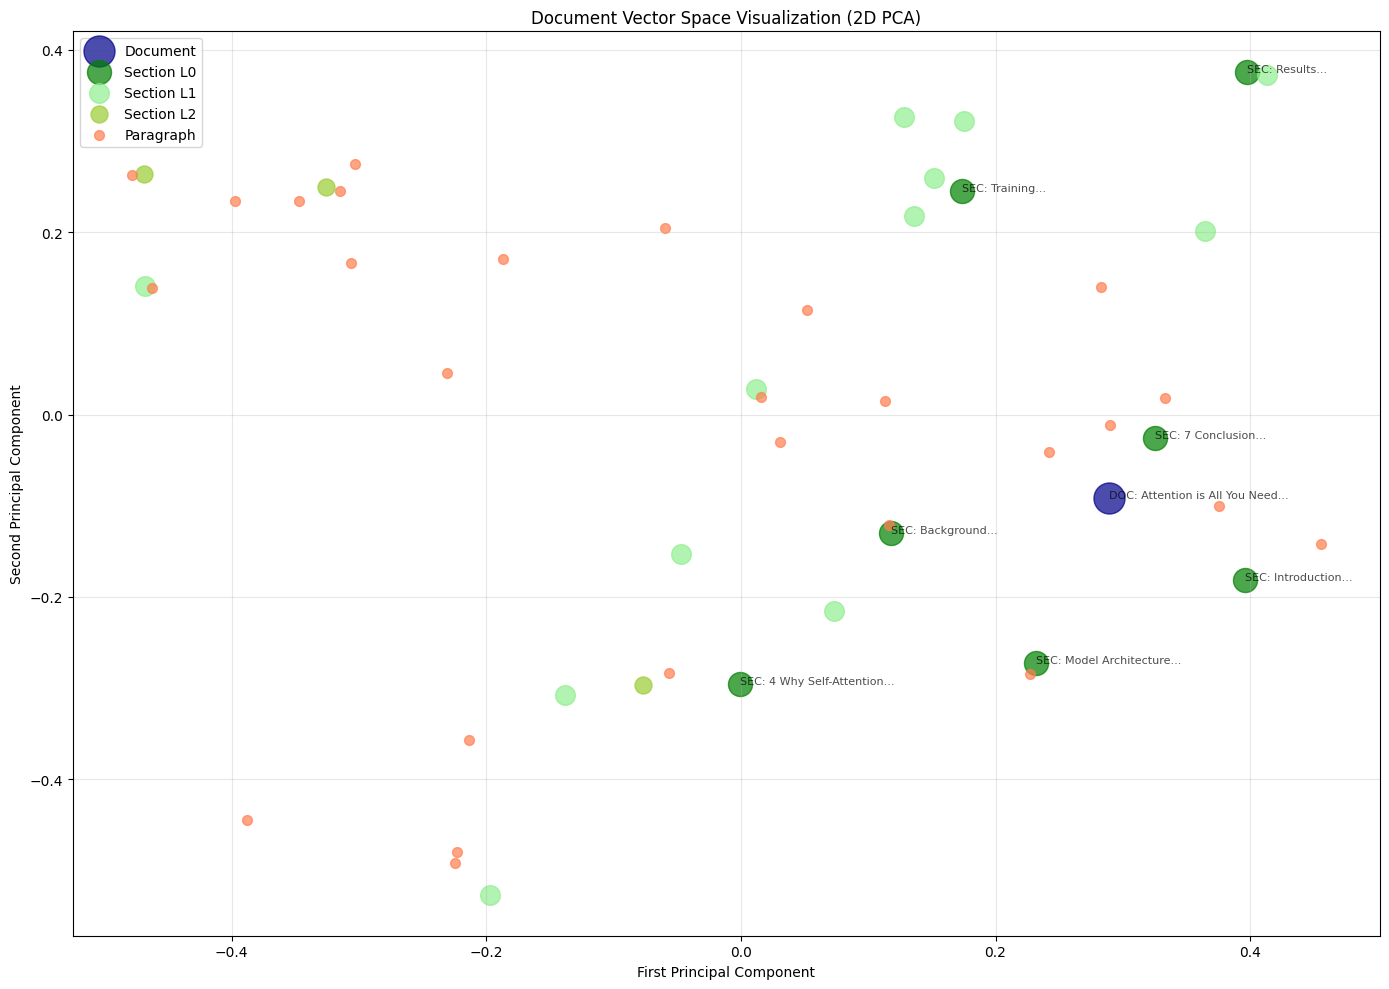

Explained variance ratio: [0.12082779 0.09868888]
Total variance explained: 21.95%


In [ ]:
### STEP 9: VISUALIZE VECTORS
### BLOCK 2: 2D visualization

# Create 2D visualization
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce to 2D
pca_2d = PCA(n_components=2)
vectors_2d = pca_2d.fit_transform(all_vectors_np)

# Create figure
plt.figure(figsize=(14, 10))

# Define colors and sizes
type_colors = {
    'document': 'darkblue',
    'section_L0': 'green',
    'section_L1': 'lightgreen',
    'section_L2': 'yellowgreen',
    'paragraph': 'coral'
}
type_sizes = {
    'document': 500,
    'section_L0': 300,
    'section_L1': 200,
    'section_L2': 150,
    'paragraph': 50
}

# Plot each type
for t in type_colors.keys():
    mask = [all_types[i] == t for i in range(len(all_types))]
    if any(mask):
        plt.scatter(
            vectors_2d[mask, 0],
            vectors_2d[mask, 1],
            c=type_colors[t],
            s=type_sizes[t],
            alpha=0.7,
            label=t.replace('_', ' ').title()
        )

# Add labels for document and main sections
for i, (label, type_) in enumerate(zip(all_labels, all_types)):
    if type_ in ['document', 'section_L0']:
        plt.annotate(label, 
                    (vectors_2d[i, 0], vectors_2d[i, 1]),
                    fontsize=8,
                    alpha=0.7)

plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Document Vector Space Visualization (2D PCA)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Explained variance ratio: {pca_2d.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca_2d.explained_variance_ratio_):.2%}")

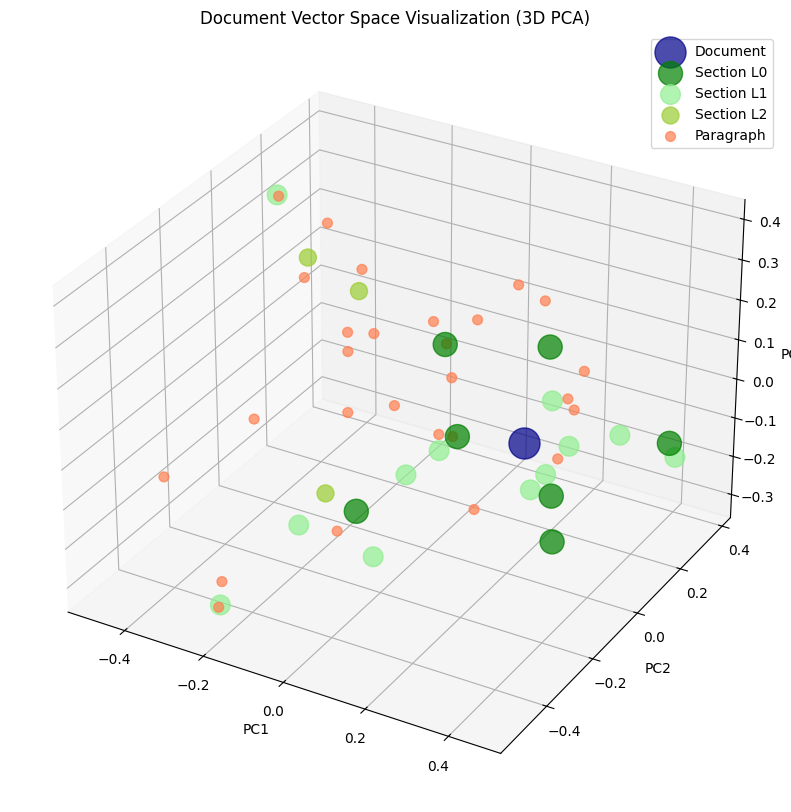

3D Explained variance ratio: [0.1208277  0.0986889  0.06965674]
3D Total variance explained: 28.92%


In [42]:
### STEP 9: VISUALIZE VECTORS
### BLOCK 3: 3D visualization

# Create 3D visualization
from mpl_toolkits.mplot3d import Axes3D

# Reduce to 3D
pca_3d = PCA(n_components=3)
vectors_3d = pca_3d.fit_transform(all_vectors_np)

# Create 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot each type
for t in type_colors.keys():
    mask = [all_types[i] == t for i in range(len(all_types))]
    if any(mask):
        ax.scatter(
            vectors_3d[mask, 0],
            vectors_3d[mask, 1],
            vectors_3d[mask, 2],
            c=type_colors[t],
            s=type_sizes[t],
            alpha=0.7,
            label=t.replace('_', ' ').title()
        )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Document Vector Space Visualization (3D PCA)')
ax.legend()

plt.show()

print(f"3D Explained variance ratio: {pca_3d.explained_variance_ratio_}")
print(f"3D Total variance explained: {sum(pca_3d.explained_variance_ratio_):.2%}")

In [43]:
### STEP 9: VISUALIZE VECTORS
### BLOCK 4: Semantic clustering

# Analyze semantic clustering
print("\n🔍 ANALYZING SEMANTIC CLUSTERING:")
print("=" * 60)

# Find closest vectors to the document vector
doc_vec = vectors['document_vector']['vector']
similarities = cosine_similarity([doc_vec], all_vectors_np)[0]

# Sort by similarity
sorted_indices = np.argsort(similarities)[::-1]

print("\nVectors most similar to the document vector:")
for i in sorted_indices[1:6]:  # Skip first (itself)
    print(f"  {all_labels[i]}: {similarities[i]:.3f}")

# Check if main sections cluster together
print("\nMain section similarities:")
main_sections = [(i, l) for i, (l, t) in enumerate(zip(all_labels, all_types)) if t == 'section_L0']
for i, (idx1, label1) in enumerate(main_sections[:3]):
    for idx2, label2 in main_sections[i+1:i+2]:
        sim = cosine_similarity([all_vectors_np[idx1]], [all_vectors_np[idx2]])[0][0]
        print(f"  {label1} ↔ {label2}: {sim:.3f}")


🔍 ANALYZING SEMANTIC CLUSTERING:

Vectors most similar to the document vector:
  PARA: The dominant sequence trans...: 0.931
  SEC: 7 Conclusion...: 0.689
  SUBSUB: Applications of Attention...: 0.614
  SEC: Introduction...: 0.570
  PARA: Recurrent neural networks, ...: 0.557

Main section similarities:
  SEC: Introduction... ↔ SEC: Background...: 0.580
  SEC: Background... ↔ SEC: Model Architecture...: 0.418
  SEC: Model Architecture... ↔ SEC: 4 Why Self-Attention...: 0.505
